<img align="center" src="../extra/logos/logos.png" width='800px'>

# Replicación de un estudio de caso

Este es parte de un ensayo para el monitoreo de humedales en la tercera región de Chile, por medio de imágenes Landsat 5-7. El objetivo, es replicar este estudio realizando algunas ligeras modificaciones. [Aquí](https://www.dataobservatory.net/2021/04/21/do-replica-estudio-de-monitoreo-de-humedal-en-atacama-mediante-plataforma-open-data-cube/) se puede encontrar mayor información sobre el estudio.

>**Nota**: Si tiene problemas para desplegar este notebook, abra una terminal de Linux (File -> New -> Terminal), navegue hasta la carpeta donde está este notebook y escriba `jupyter trust 03_Estudio_caso.ipynb`. Luego, vuelva a abrir el notebook.

In [1]:
%matplotlib inline

import sys
import numpy as np
import pandas as pd
import datacube
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
from datacube.utils.cog import write_cog
from datacube.utils.masking import make_mask, mask_invalid_data, describe_variable_flags

sys.path.append("../../datacube-notebooks-public/Scripts")
from deafrica_plotting import display_map, rgb

In [2]:
dc = datacube.Datacube(app="Humedales")

Definir el Área de estudio (un rectángulo por el momento)

In [3]:
study_area_lat = (-27.446, -27.327) # (ymin, ymax)
study_area_lon = (-69.067, -68.966) # (xmin, xmax)

In [4]:
display_map(x=study_area_lon, y=study_area_lat)

Si se listan los productos, podemos ver el rango de fechas en que están disponibles los productos de Landsat para reflectancia de la superficie.

In [5]:
dc.list_products()

,name,description,platform,product_family,label,format,creation_time,time,dataset_maturity,lat,region_code,instrument,lon,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,,,
8,fasat_charlie,FASat Charlie data,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN
15,s2_l2a,"Sentinel-2a and Sentinel-2b imagery, processed...",None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN
10,srtm,1 arc second elevation model,None,None,None,None,None,None,None,None,None,None,None,EPSG:4326,"(-0.0002777777777777778, 0.0002777777777777778)",NaN,"(latitude, longitude)"
9,ultracam_saf,LEARJET con ULTRACAM (SAF),None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN
13,usgs_aws_ls5c2_sr,Landsat 5 USGS Collection 2 Surface Reflectanc...,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN
12,usgs_aws_ls7c2_sr,Landsat 7 USGS Collection 2 Surface Reflectanc...,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN
14,usgs_aws_ls8c2_sr,Landsat 8 USGS Collection 2 Surface Reflectanc...,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN
1,usgs_espa_ls5c1_sr,Landsat 5 USGS Collection 1 Surface Reflectanc...,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN
2,usgs_espa_ls7c1_sr,Landsat 7 USGS Collection 1 Surface Reflectanc...,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN


In [6]:
products = [f[1]['name'] for f in dc.list_products().iterrows() if 'Landsat' in f[1].description if 'Surface' in f[1].description]
products

['usgs_aws_ls5c2_sr',
 'usgs_aws_ls7c2_sr',
 'usgs_aws_ls8c2_sr',
 'usgs_espa_ls5c1_sr',
 'usgs_espa_ls7c1_sr',
 'usgs_espa_ls8c1_sr']

In [7]:
dc.list_measurements().loc[products]

name   dtype        units  nodata  \
product            measurement                                            
usgs_aws_ls5c2_sr  blue               blue  uint16  reflectance     0.0   
                   green             green  uint16  reflectance     0.0   
                   red                 red  uint16  reflectance     0.0   
                   nir                 nir  uint16  reflectance     0.0   
                   swir1             swir1  uint16  reflectance     0.0   
...                                    ...     ...          ...     ...   
usgs_espa_ls8c1_sr swir1             swir1   int16  reflectance -9999.0   
                   swir2             swir2   int16  reflectance -9999.0   
                   pixel_qa       pixel_qa  uint16    bit_index     1.0   
                   aerosol_qa   aerosol_qa   uint8    bit_index     1.0   
                   radsat_qa     radsat_qa  uint16    bit_index     1.0   

                                                   aliases  \
product            measurement                               
usgs_aws_ls5c2_sr  blue          [SR_B1, sr_band1, band_1]   
                   green         [SR_B2, sr_band2, band_2]   
                   red           [SR_B3, sr_band3, band_3]   
                   nir           [SR_B4, sr_band4, band_4]   
                   swir1         [SR_B5, sr_band5, band_5]   
...                                                    ...   
usgs_espa_ls8c1_sr swir1                [sr_band6, band_6]   
                   swir2                [sr_band7, band_7]   
                   pixel_qa     [pixel_quality, level2_qa]   
                   aerosol_qa                 [sr_aerosol]   
                   radsat_qa               [saturation_qa]   

                                                                 flags_definition  
product            measurement                                                     
usgs_aws_ls5c2_sr  blue                                                       NaN  
                   green                                                      NaN  
                   red                                                        NaN  
                   nir                                                        NaN  
                   swir1                                                      NaN  
...                                                                           ...  
usgs_espa_ls8c1_sr swir1                                                      NaN  
                   swir2                                                      NaN  
                   pixel_qa     {'snow': {'bits': 4, 'values': {'0': 'no_snow'...  
                   aerosol_qa   {'cloud': {'bits': 3, 'values': {'0': False, '...  
                   radsat_qa    {'data_fill': {'bits': 0, 'values': {'0': 'val...  

[87 rows x 6 columns]

Ahora que se tiene mayor claridad, sobre los productos, podemos especificar las bandas de interes, y revisar sus fechas. Primero configuramos la consulta

In [8]:
set_measurements = [
    "blue",
    "green",
    "red",
    "nir",
    "pixel_qa",
    "radsat_qa"
]

set_crs = 'EPSG:32719'

set_resolution = (-30, 30)

Se quieren las bandas azul, verde, roja e infrarroja, para armar los índices más conocidos. También se solicitan las bandas de calidad, para filtrar las nubes y otros artefactos.

La resolución espacial que se pide es de 30x30 metros y queremos que la imagen esté en WGS84 UTM 19 SUR (EPSG: 32719)

In [9]:
images = {}
for set_product in products:
    images[set_product] = dc.load(
        product=set_product,
        x=study_area_lon,
        y=study_area_lat,
        # time=set_time,
        measurements=set_measurements,
        output_crs=set_crs,
        resolution=set_resolution,
        dask_chunks={"time": 1},
        group_by="solar_day"
    )

In [10]:
pd.DataFrame( {v: [min(images[v].time.values), max(images[v].time.values)] for v in images if images[v]} )

,usgs_aws_ls5c2_sr,usgs_aws_ls7c2_sr,usgs_aws_ls8c2_sr,usgs_espa_ls5c1_sr,usgs_espa_ls7c1_sr,usgs_espa_ls8c1_sr
0,1984-12-24 14:02:15.660069,1999-07-19 14:24:52.208322,2013-04-02 14:29:35.097190,1984-12-24 14:02:15.660069,1999-07-19 14:24:52.208322,2013-04-02 14:29:35.097190
1,2011-11-17 14:19:30.779088,2021-02-05 13:48:01.255117,2021-04-02 14:31:50.814078,2011-11-17 14:19:30.779088,2020-12-03 13:52:39.119795,2020-08-21 14:32:08.989854


Se usarán imágenes landsat 5 y 7, debido a la compatibilidad radiométrica

In [11]:
desired_products = ['usgs_espa_ls5c1_sr', 'usgs_espa_ls7c1_sr']

ds = xr.concat([images[i] for i in desired_products], dim='time')

## Enmascaramiento de valores no válidos

En este primer paso, se aplicará una máscara para la nubosidad, utilizando la banda de calidad de Landsat. Para Landsat 8, un resumen de los valores apropiados puede ser encontrado [aquí](https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1368_L8_C1-LandSurfaceReflectanceCode-LASRC_ProductGuide-v3.pdf).

Siguiendo esa guía como paso, se fijan los valores válidos (libres de nubes) los que pertenezcan a la siguiente lista. Si la banda de calidad tiene alguno de estos valores, se considera que dicho pixel no tiene nubes.

In [12]:
describe_variable_flags(ds)

,bits,values,description
snow,4,"{'0': 'no_snow', '1': 'snow'}",NaN
clear,1,"{'0': 'no_clear_land', '1': 'clear_land'}",NaN
cloud,5,"{'0': 'no_cloud', '1': 'cloud'}",NaN
water,2,"{'0': 'no_water', '1': 'water'}",NaN
nodata,0,"{'0': False, '1': True}",NaN
pixel_qa,"[0, 1, 2, 3, 4, 5, 6, 7]","{'1': 'Fill', '2': 'Clear', '4': 'Water', '8':...",Level 2 pixel quality
cloud_shadow,3,"{'0': 'no_cloud_shadow', '1': 'cloud_shadow'}",NaN
cloud_confidence,"[6, 7]","{'0': 'none', '1': 'low', '2': 'medium', '3': ...",NaN


In [13]:
reflectance_names = ["red", "blue", "green", "nir"]

mask = make_mask(ds.pixel_qa, cloud='no_cloud', cloud_shadow='no_cloud_shadow', snow='no_snow') # genera máscara de nubes, nieve y datos inválidos
ds_cloud_free = ds[reflectance_names].where(mask)
ds_nans = mask_invalid_data(ds_cloud_free[reflectance_names]) # aplica la máscara de nubes
ds_nans = ds_nans.where((ds_nans >= 0) & (ds_nans<=10000)) # rango válido de datos
ds_nans = ds_nans.where( np.logical_not(ds_nans.isin([-9999, 20000])) ) # valores que mabrcan píxeles sin datos
ds_nans = ds_nans.where( ds.radsat_qa == 0 ) # pixeles no saturados

In [14]:
ds.update(ds.where(mask, np.nan)) # este método funciona mejor que sobreescribir

<xarray.Dataset>
Dimensions:      (time: 871, x: 334, y: 441)
Coordinates:
  * time         (time) datetime64[ns] 1984-12-24T14:02:15.660069 ... 2020-12...
  * y            (y) float64 6.977e+06 6.977e+06 ... 6.964e+06 6.964e+06
  * x            (x) float64 4.934e+05 4.934e+05 ... 5.033e+05 5.034e+05
    spatial_ref  int32 32719
Data variables:
    blue         (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    nir          (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    pixel_qa     (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    radsat_qa    (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

Se puede apreciar del objeto, que se tienen 871 mediciones combinadas entre landsat 5 landsat 8

## Calculando índices

Los índices de vegetación son muy utilizados en el monitreo del estado de la vegetación, entre otros fenómenos de interés. Uno de los más usados para ver el estado de vigor (y uno de las más antiguos), es el NDVI que utiliza las bandas rojo e infra-rojo cercano.

Se usará este índice a modo de mostración, pero se podría utilizar cualquier otro.

**Nota importante**: cada banda del producto está en valores enteros (int16), para indicar la reflectancia. Se guardan de esta manera para disminuir el tamaño del archivo, pero antes de realizar cálculos, deben ser escalados de vuelta a valores decimales contenidos entre [0, 1]. Este factor de escalamiento es de 0.0001 y está especificado en la [documentación](https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1368_L8_C1-LandSurfaceReflectanceCode-LASRC_ProductGuide-v3.pdf).

In [15]:
ndvi = (ds.nir*.0001 - ds.red*.0001) / (ds.nir*.0001 + ds.red*.0001)

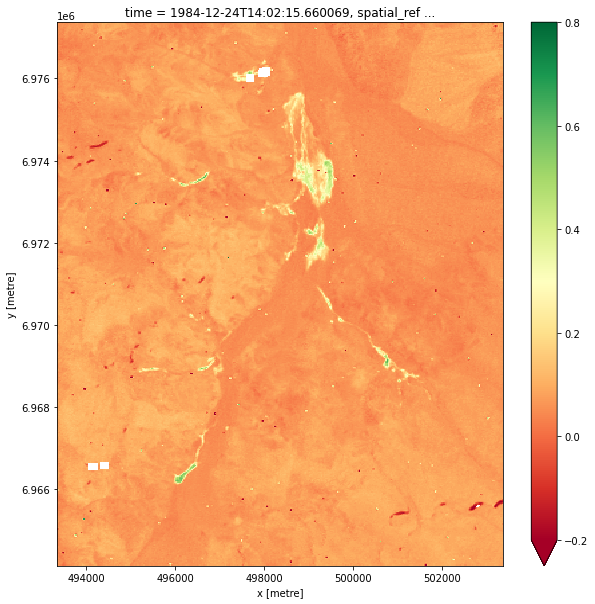

In [16]:
plt.figure(figsize=(10, 10))
ndvi.isel(time=0).plot(cmap="RdYlGn", vmin=-.2, vmax=.8)
plt.show()

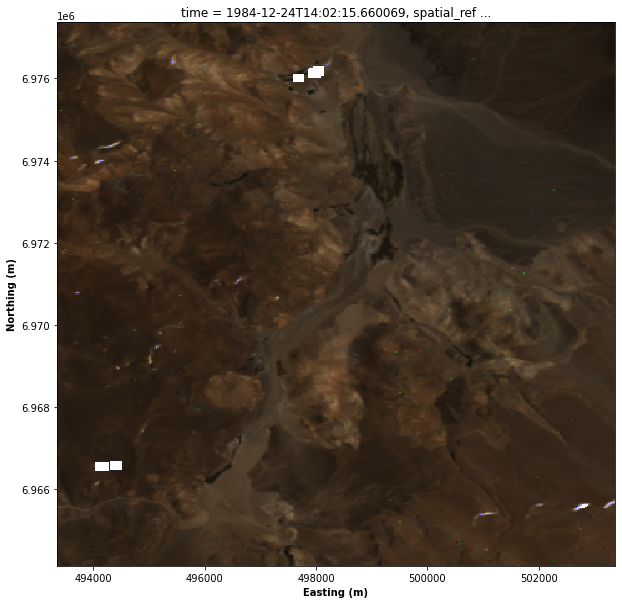

In [17]:
ds[["red", "green", "blue"]].isel(time=0).to_array().plot.imshow(vmin=0,vmax=10000,figsize=(10,10))

# Set the title and axis labels
ax = plt.gca()
ax.set_xlabel('Easting (m)', fontweight='bold')
ax.set_ylabel('Northing (m)', fontweight='bold')

# Display the plot
plt.show()

Se agrega el NDVI como una variable más al cubo

In [18]:
ds = ds.assign(ndvi=ndvi)
ds

<xarray.Dataset>
Dimensions:      (time: 871, x: 334, y: 441)
Coordinates:
  * time         (time) datetime64[ns] 1984-12-24T14:02:15.660069 ... 2020-12...
  * y            (y) float64 6.977e+06 6.977e+06 ... 6.964e+06 6.964e+06
  * x            (x) float64 4.934e+05 4.934e+05 ... 5.033e+05 5.034e+05
    spatial_ref  int32 32719
Data variables:
    blue         (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    nir          (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    pixel_qa     (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    radsat_qa    (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    ndvi         (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

## Revisando sólo las zonas de interés (humedales)

Es necesario descargar los archivos vectoriales que contienen los humedales. En este caso, se usarán los del ministerio de medio ambiente, para el año 2015, los que pueden ser visualizados y descargados en el [visor oficial](https://gis.mma.gob.cl/portal/apps/webappviewer/index.html?id=19ff876d63ed4a53aef1a57e39370474). Para ir directo a la descarga, se puede usar este otro [sitio](https://humedaleschile.mma.gob.cl/inventario-humadales/) del ministerio.

In [19]:
import urllib.request
import os

if not os.path.exists("humedales_vector.zip"):
    urllib.request.urlretrieve("https://humedaleschile.mma.gob.cl/wp-content/uploads/2017/10/inventario_humedales_publico.gdb.zip", "humedales_vector.zip")

In [20]:
import geopandas as gpd
import rasterstats as rs
import pyproj
from shapely.geometry import Polygon

In [21]:
humedales = gpd.read_file('zip://humedales_vector.zip!Inventario_humedales_publico.gdb', layer='inventario_plataforma')

/env/lib/python3.6/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [22]:
y0, y1 = study_area_lat
x1, x0 = study_area_lon
polygon = Polygon([(x0, y0), (x0, y1), (x1, y1), (x1, y0), (x0, y0)])
clipper = gpd.GeoDataFrame([1], geometry=[polygon], crs=pyproj.CRS("EPSG:4326"))
clipper = clipper.to_crs(humedales.crs)
# clipper.plot()
humedales_ = gpd.clip(humedales, clipper)
humedales_ = humedales_.loc[humedales_.Clase != "Rios"]

Más información sobre [como armar geometrías y como cortar geometrías](https://geopandas.org/gallery/plot_clip.html). Un vistazo al archivo vectorial:

<AxesSubplot:>

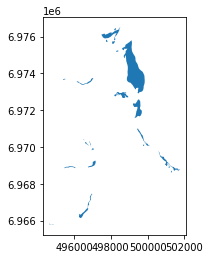

In [23]:
humedales_.plot()

<AxesSubplot:>

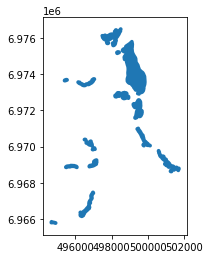

In [24]:
humedales_or = humedales_.copy()
humedales_['geometry'] = humedales_.geometry.buffer(100)
humedales_.plot()

## Agrupar datos por tiempo

En primera instancia, calcular la mediana entre los meses de diciembre, enero, febrero y marzo de cada año. Primero, se arma un vector con las fechas de interés que están en el cubo, y se genera un subset

In [25]:
summer_dates = ds.time[ds.time.dt.month.isin([12, 1, 2, 3])]
ds_summer = ds.sel(time=summer_dates)

Es necesario generar una variable por temporada. Diciembre (12), pertenece al año anterior, por lo que no se puede utilizar el año directamente. Se toma la coordenada de base `time` y se le adicionan 31 días (aquí nos interesa el año, no el mes, por lo tanto no hay problema al hacerlo de esta forma).

En la zona están presentes algunas escenas que están "movidas"

In [26]:
moved_scenes = ['1992-05-20', '1995-05-13', '1996-01-08', '1996-01-24', '1996-03-12', '1998-05-21', '1998-09-26', '1998-10-28', 
                '1998-11-13', '1998-12-15', '1999-04-22', '1999-05-08', '1999-10-23', '1999-10-31', '1999-11-16', '2001-03-26', 
                '2001-04-11', '2001-08-09', '2001-11-05', '2002-06-09', '2003-01-19', '2006-01-27', '2006-03-16', '2006-04-01', 
                '2008-11-08', '2009-11-11', '2011-03-06', '2011-03-22', '2011-08-05', '2012-01-12', '2012-10-26', '2013-11-30', 
                '2014-04-07', '2014-05-09', '2014-11-17', '2015-01-04']
ds_summer = ds_summer.sel(time=~ds_summer.time.dt.strftime("%Y-%m-%d").isin(moved_scenes))

In [27]:
ds_summer = ds_summer.assign_coords(season=(ds_summer.time + np.timedelta64(31, 'D')))
ds_summer

<xarray.Dataset>
Dimensions:      (time: 279, x: 334, y: 441)
Coordinates:
  * time         (time) datetime64[ns] 1984-12-24T14:02:15.660069 ... 2020-12...
  * y            (y) float64 6.977e+06 6.977e+06 ... 6.964e+06 6.964e+06
  * x            (x) float64 4.934e+05 4.934e+05 ... 5.033e+05 5.034e+05
    spatial_ref  int32 32719
    season       (time) datetime64[ns] 1985-01-24T14:02:15.660069 ... 2021-01...
Data variables:
    blue         (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    nir          (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    pixel_qa     (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    radsat_qa    (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    ndvi         (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

La coordenada ha sido añadida satisfactoriamente, por lo que ahora se puede usar como variable de agrupamiento y calcular la mediana de la temporada (ignorando valores ausentes)

In [28]:
# ds_summer = ds_summer.groupby('season.year').reduce(np.nanmean)  # más lento: favorecer las funciones de xarray
ds_summer_ag = ds_summer.groupby('season.year').median(skipna=True).persist()
# ds_summer = ds_summer.groupby('season.year').mean(skipna=True)
ds_summer_ag

/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


<xarray.Dataset>
Dimensions:      (x: 334, y: 441, year: 37)
Coordinates:
  * y            (y) float64 6.977e+06 6.977e+06 ... 6.964e+06 6.964e+06
  * x            (x) float64 4.934e+05 4.934e+05 ... 5.033e+05 5.034e+05
    spatial_ref  int32 32719
  * year         (year) int64 1985 1986 1987 1988 1989 ... 2018 2019 2020 2021
Data variables:
    blue         (year, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    green        (year, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    red          (year, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    nir          (year, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    pixel_qa     (year, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    radsat_qa    (year, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    ndvi         (year, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>

La serie temporal agregada está lista, podemos visualizarla para el 2014 (en color y el índice NDVI):

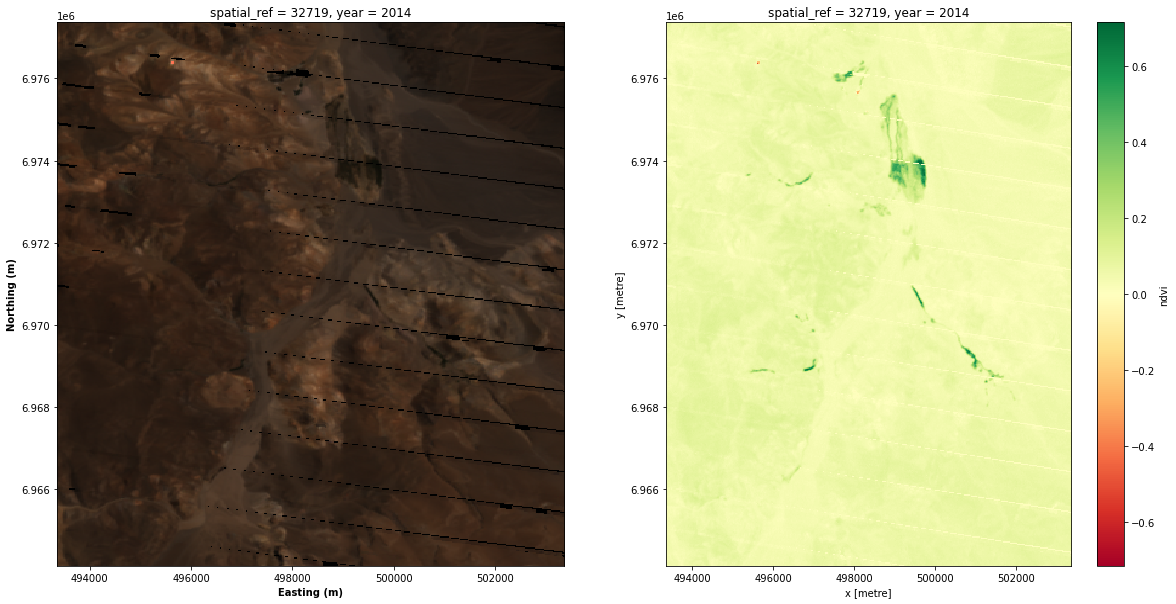

In [29]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)

ds_summer_ag[["red", "green", "blue"]].sel(year=2014).to_array().plot.imshow(vmin=0,vmax=10000,ax=ax1) #figsize=(10,10)
ax1.set_xlabel('Easting (m)', fontweight='bold')
ax1.set_ylabel('Northing (m)', fontweight='bold')

ax2 = fig.add_subplot(122)
ds_summer_ag['ndvi'].sel(year=2014).plot.imshow(cmap="RdYlGn", ax=ax2)

Si se enmascara la zona particular de estudio, el resultado se ve más limpio:

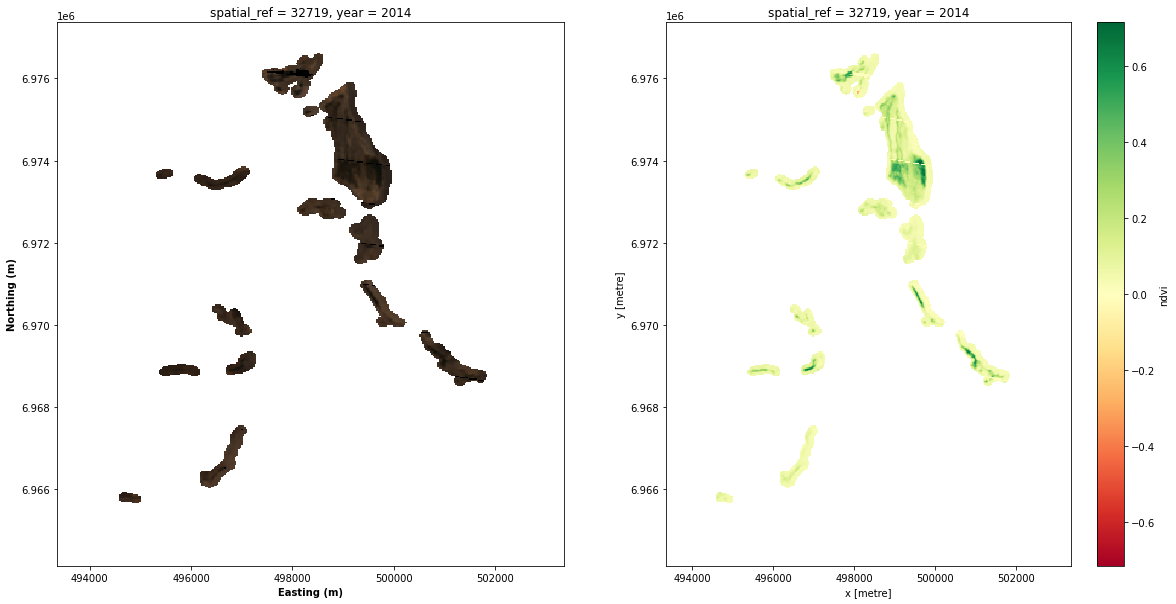

In [30]:
import rasterio as rio

smask = rio.features.geometry_mask(humedales_.geometry, 
                                   out_shape=(len(ds.y), len(ds.x)),
                                   transform=ds.geobox.transform,
                                   invert=True)

ds_summer_masked = ds_summer_ag.where(smask)


fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)

ds_summer_masked[["red", "green", "blue"]].sel(year=2014).to_array().plot.imshow(vmin=0,vmax=10000,ax=ax1) #figsize=(10,10)
ax1.set_xlabel('Easting (m)', fontweight='bold')
ax1.set_ylabel('Northing (m)', fontweight='bold')

ax2 = fig.add_subplot(122)
ds_summer_masked['ndvi'].sel(year=2014).plot.imshow(cmap="RdYlGn", ax=ax2)

Y si además se sobreponen los contornos:

<AxesSubplot:title={'center':'spatial_ref = 32719, year = 2014'}, xlabel='x [metre]', ylabel='y [metre]'>

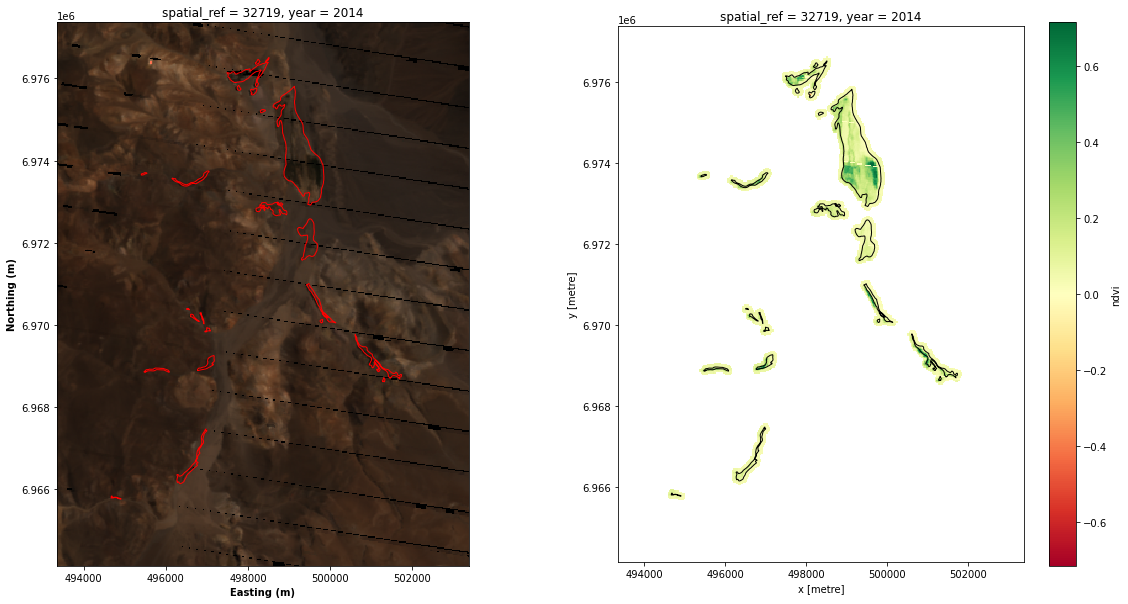

In [31]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)

ds_summer_ag[["red", "green", "blue"]].sel(year=2014).to_array().plot.imshow(vmin=0,vmax=10000,ax=ax1) #figsize=(10,10)
humedales_or.plot(ax=ax1, facecolor='none', edgecolor='red')
ax1.set_xlabel('Easting (m)', fontweight='bold')
ax1.set_ylabel('Northing (m)', fontweight='bold')

ax2 = fig.add_subplot(122)
ds_summer_masked['ndvi'].sel(year=2014).plot.imshow(cmap="RdYlGn", ax=ax2)
humedales_or.plot(ax=ax2, facecolor='none', edgecolor='black')

Finalmente, la información puede ser exportada como netcdf, para ser utilizada en otras plataformas/programas

In [32]:
from datacube.drivers.netcdf import write_dataset_to_netcdf
import warnings
warnings.filterwarnings('ignore')

if os.path.exists('humedales.nc'):
    os.remove('humedales.nc')
    
write_dataset_to_netcdf(ds_summer_masked, 'humedales.nc')

## Extracción de datos por zona (zonal statitics)

Se itera por cada año y extraemos las estadísticas. Hay que procurar que tanto el archivo vectorial como el xarray tengan el mismo CRS. 

0 - 1985
5 - 1990
10 - 1995
15 - 2000
20 - 2005
25 - 2010
30 - 2015
35 - 2020


<AxesSubplot:xlabel='Año'>

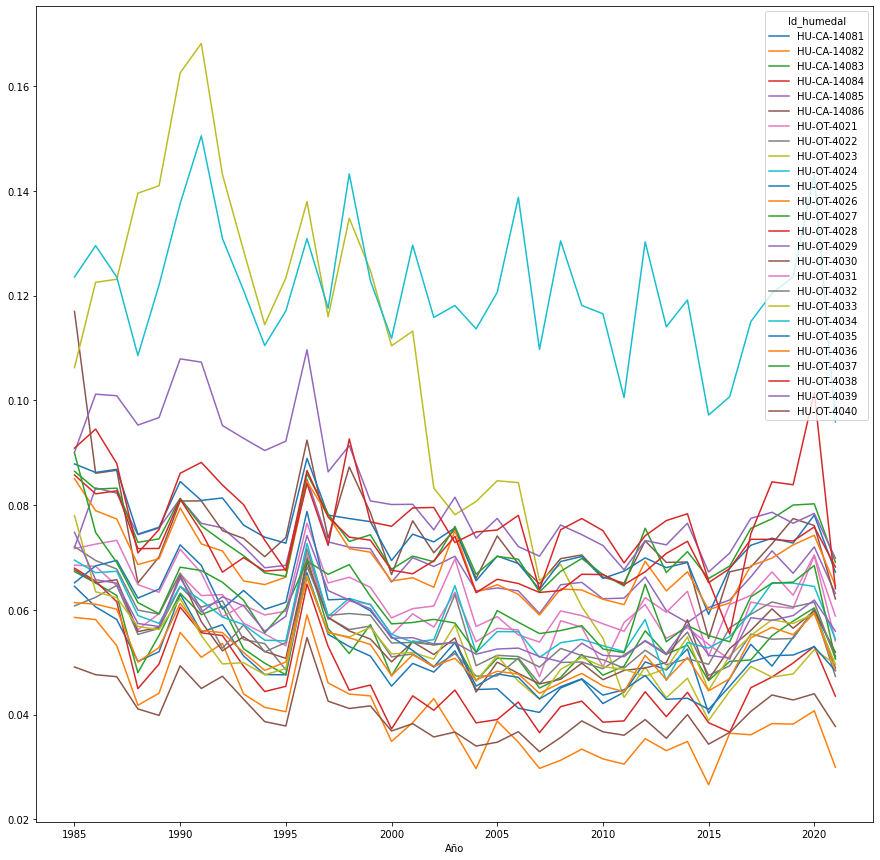

In [33]:
my_stats = []
for i, date in enumerate(ds_summer_ag.year.values):
    if i % 5 == 0:
        print('{} - {}'.format(i, date))
    temp = rs.zonal_stats(humedales_, 
                          ds_summer_ag.ndvi.isel(year=i).values, 
                          affine=ndvi.affine, 
                          stats="count min mean max median std", 
                          nodata=np.nan) # especificar no data, solo para evitar advertencias. Los valores NA ya están como np.nan
    temp_ = pd.merge(pd.DataFrame(humedales_.reset_index().drop(columns="geometry")), 
                             pd.DataFrame(temp), 
                             left_index=True, 
                             right_index=True)
    temp_['Año'] = date
    my_stats.append(temp_)

serie_temporal = pd.concat(my_stats)
pd.pivot(serie_temporal, index="Año", columns='Id_humedal', values="median").plot(figsize=(15,15))

Se puede seleccionar un humedal en particular

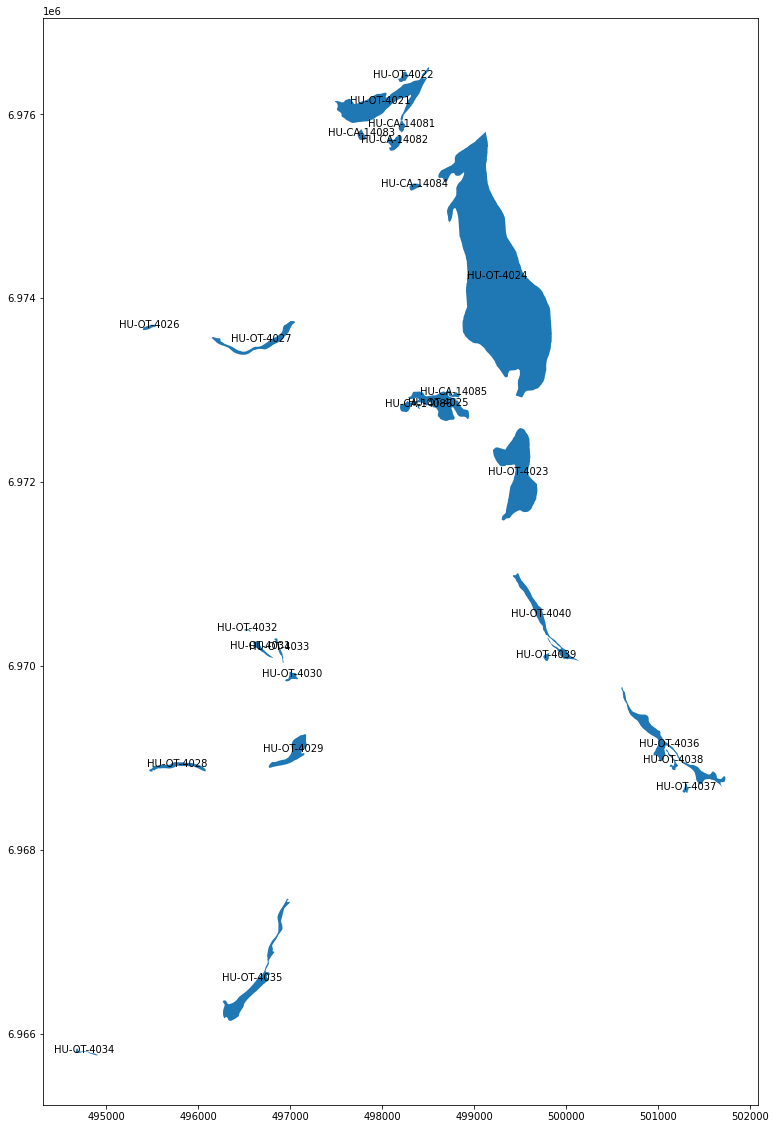

In [34]:
ax = humedales_or.plot(figsize=(20, 20))
humedales_or.apply(lambda x: ax.annotate(s=x.Id_humedal, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);

Los humedales de interés son:

In [35]:
humedales_id = ['HU-OT-4023', # humedal objetivo
               'HU-OT-4028', 'HU-OT-4029', 'HU-OT-4030', 'HU-OT-4031', 'HU-OT-4033', 'HU-OT-4040'] # humedales control

Aislando el humedal objetivo:

<AxesSubplot:xlabel='Año'>

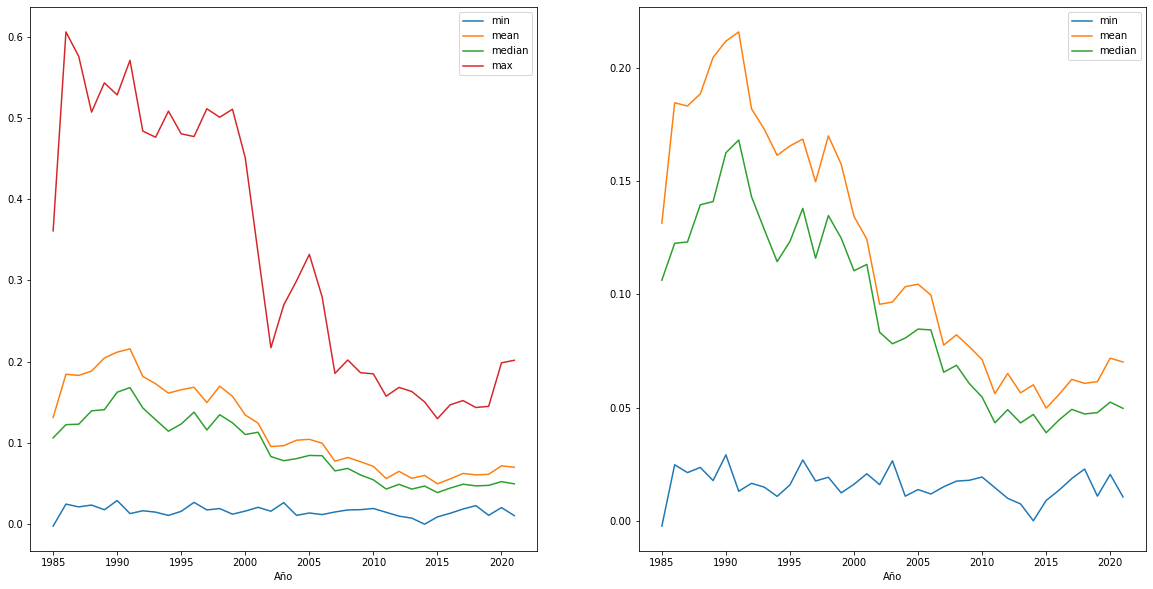

In [36]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

agg_ = serie_temporal.loc[serie_temporal.Id_humedal == humedales_id[0]].set_index('Año')[['min', 'mean', 'median', 'max']]

agg_.plot(ax = ax1) #, subplots=True)
agg_[['min', 'mean', 'median']].plot(ax = ax2) #, subplots=True)

Comparando el humedal objetivo con los de control (en su media y viendo su tendencia general):

<AxesSubplot:xlabel='Año'>

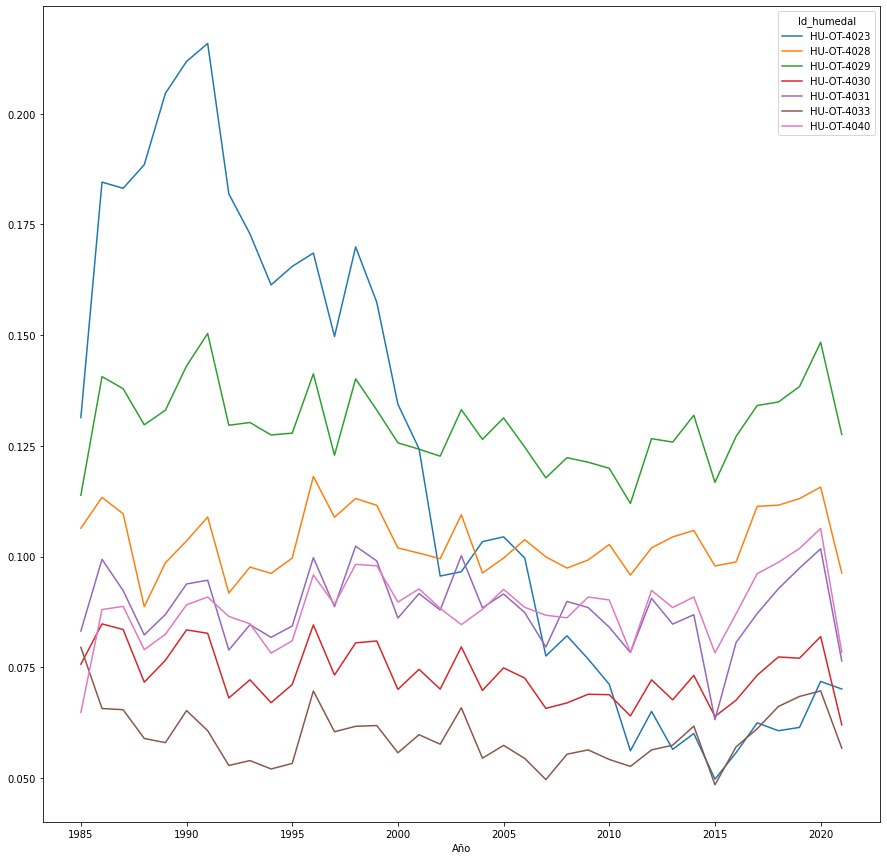

In [37]:
compara = serie_temporal.loc[serie_temporal.Id_humedal.isin(humedales_id)][['Año', 'Id_humedal', 'mean']]
pd.pivot(compara, index="Año", columns='Id_humedal', values="mean").plot(figsize=(15,15))

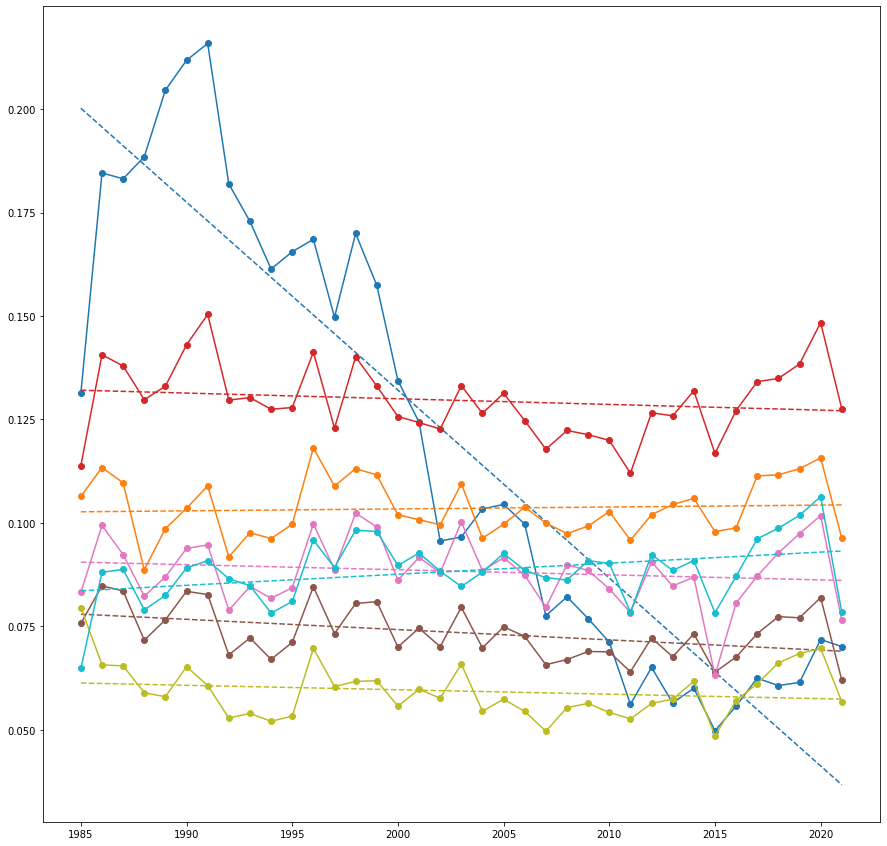

In [38]:
cmap = plt.cm.tab10
colores = cmap(np.linspace(0, 1, len(humedales_id)))
colores = {humedales_id[i]: colores[i] for i in range(len(humedales_id))}

fig, ax = plt.subplots(figsize=(15, 15))

for i in humedales_id:
    temp = serie_temporal.loc[serie_temporal.Id_humedal == i]
    x, y = temp[['Año', 'mean']].T.to_numpy()
    plt.plot(x, y, '-o', color=colores[i])
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "--", color=colores[i])

Los resultados son bastante similares a los obtenidos por el MMA y se ve claramente que el humedal en cuestión (HU-OT-4023, en azul), tiene un marcado descenso que no está presente en el resto de los humedales

## *Siguientes pasos*

Para continuar el entrenamiento, un listado con los notebooks de esta sesión

1. [Acceso y configuración](00_Acceso_configuración.ipynb)
2. [Cargar datos](01_Carga_datos.ipynb)
3. [Análisis básico](02_Análisis_básico.ipynb)
4. **Estudio de caso**
5. [Trabajo final](04_Actividad_final.ipynb)